## Implementation of subspace alignment

This is based on the following paper: <i>Unsupervised Visual Domain Adaptation Using Subspace Alignment</i>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow_hub as hub

import warnings
warnings.filterwarnings("ignore")

In [2]:
## feature extraction using pretrained feature extractor
universal_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
nnlm_embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")

In [3]:
## getting the data from the different distributions
def get_data(file_name,data_dir="../data/sentiment/"):
    """ returns the sentiment data for the given file
    """
    all_text = []
    all_labels = []
    with open(data_dir+file_name) as data_file:
        for line in data_file.readlines():
            text,label = line.split("\t")
            all_text.append(text.lower())
            all_labels.append(int(label))
    return np.asarray(all_text),np.asarray(all_labels)

amazon_x,amazon_y = get_data("amazon.txt")
imdb_x,imdb_y = get_data("imdb.txt")
print(amazon_x.shape,amazon_y.shape,imdb_x.shape,imdb_y.shape)
amazon_x = np.hstack([universal_embed(amazon_x),nnlm_embed(amazon_x)])
imdb_x = np.hstack([universal_embed(imdb_x),nnlm_embed(imdb_x)])
print(amazon_x.shape,imdb_x.shape)

(1000,) (1000,) (1000,) (1000,)
(1000, 640) (1000, 640)


0.8911493957275525


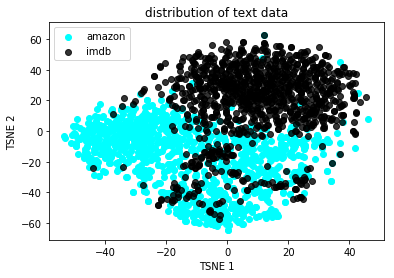

In [4]:
## distribution of data prior to the subspace alignment transformation
pca = PCA(n_components=200)
both_features = np.vstack([amazon_x,imdb_x])
combined_pca = pca.fit_transform(both_features)
print(sum(pca.explained_variance_ratio_))

tsne_embed = TSNE(n_components=2).fit_transform(combined_pca)
tsne_amazon = tsne_embed[:1000,:]
tsne_imdb = tsne_embed[1000:,:]
plt.scatter(tsne_amazon[:,0],tsne_amazon[:,1],color="cyan",label="amazon",)
plt.scatter(tsne_imdb[:,0],tsne_imdb[:,1],color="black",label="imdb",alpha=0.8)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("distribution of text data")
plt.legend()
plt.show()

### Subspace alignment

Treating the IMDB data as being the target, so the Amazon data will be transformed.

In [5]:
pca = PCA(n_components=200)
amazon_pca = pca.fit_transform(amazon_x)
source = pca.components_
print(sum(pca.explained_variance_ratio_))

pca = PCA(n_components=200)
imdb_pca = pca.fit_transform(imdb_x)
target = pca.components_
print(sum(pca.explained_variance_ratio_))

print(source.shape,target.shape)
print(amazon_pca.shape,imdb_pca.shape)

0.9211432093870826
0.9136329828179441
(200, 640) (200, 640)
(1000, 200) (1000, 200)


In [6]:
# Calculating the transformation matrix
M = source.dot(target.T)
M.shape

(200, 200)

In [7]:
# Getting the transformed Amazon data
new_imdb_x = imdb_pca
new_amazon_x = amazon_pca.dot(M)
print(new_amazon_x.shape)

(1000, 200)


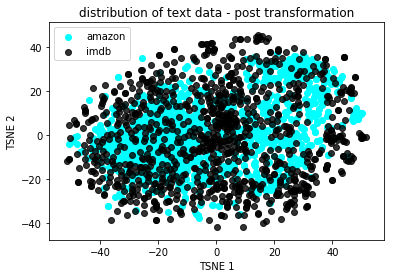

In [8]:
## text distributions more closely match than they did before
tsne_embed = TSNE(n_components=2).fit_transform(np.vstack([new_amazon_x,new_imdb_x]))
tsne_amazon = tsne_embed[:1000,:]
tsne_imdb = tsne_embed[1000:,:]
plt.scatter(tsne_amazon[:,0],tsne_amazon[:,1],color="cyan",label="amazon",)
plt.scatter(tsne_imdb[:,0],tsne_imdb[:,1],color="black",label="imdb",alpha=0.8)
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("distribution of text data - post transformation")
plt.legend()
plt.show()